In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

from classiq import *
from classiq.applications.iqae.iqae import IQAE

In [2]:
# How many qubits we want the quantum circuit to be
num_qubits = 7

# Mu (μ) represents the Average
mu = 0.7

# Sigma (σ) represents the Standard Deviation
sigma = 0.13

# The Alpha (α) parameter represents the probability in which P(X > v) = 1 - α
ALPHA = 0.07

# Find Alpha in a given precision
TOLERANCE = ALPHA / 10


def get_log_normal_probabilities(mu_normal, sigma_normal, num_points):
    log_normal_mean = np.exp(mu + sigma**2 / 2)
    log_normal_variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
    log_normal_stddev = np.sqrt(log_normal_variance)

    # cutting the distribution 3 sigmas from the mean
    low = np.maximum(0, log_normal_mean - 3 * log_normal_stddev)
    high = log_normal_mean + 3 * log_normal_stddev
    print(log_normal_mean, log_normal_variance, log_normal_stddev, low, high)
    x = np.linspace(low, high, num_points)
    return x, scipy.stats.lognorm.pdf(x, s=sigma_normal, scale=np.exp(mu_normal))


# %%
grid_points, probs = get_log_normal_probabilities(mu, sigma, 2**num_qubits)

2.030841014265948 0.07029323208790372 0.26512870853210846 1.2354548886696226 2.8262271398622736


Value at risk at 7%: 1.6613309244219858


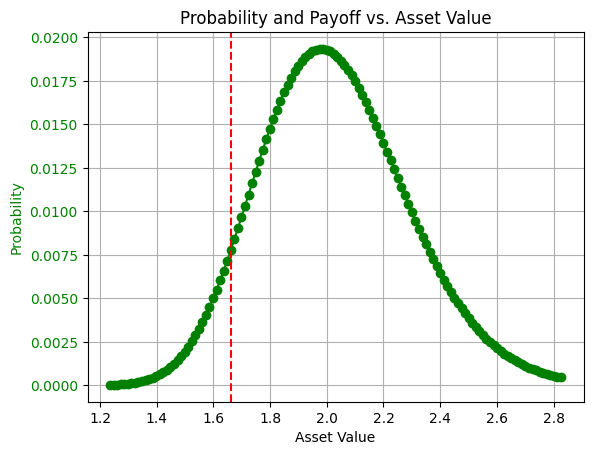

In [3]:
probs = (probs / np.sum(probs)).tolist()

fig, ax1 = plt.subplots()

# Plotting the log-normal probability function
ax1.plot(grid_points, probs, "go-", label="Probability")  # Green line with circles
ax1.tick_params(axis="y", labelcolor="g")
ax1.set_xlabel("Asset Value")
ax1.set_ylabel("Probability", color="g")

# Adding grid and title
ax1.grid(True)
plt.title("Probability and Payoff vs. Asset Value")

VAR = 0
# Find the value at risk ALPHA of grid_points
accumulated_value = 0

for index in range(len(probs)):
    accumulated_value += probs[index]
    if accumulated_value > ALPHA:
        VAR = grid_points[index]
        break

print(f"Value at risk at {int(ALPHA*100)}%: {VAR}")

# Plot the vertical line of VaR at 5%
ax1.axvline(x=VAR, color="r", linestyle="--", label="VaR at 5%")

In [4]:
def get_initial_index():
    return int(2**num_qubits) // 4

In [5]:
def update_index(index: int, required_alpha: float, alpha_v: float, search_size: int):
    if alpha_v < required_alpha:
        return index + search_size
    return index - search_size

In [6]:
# This function calculates the alpha classically given the index and the list of probabilities


def calc_alpha(index: int, probs: list[float]):
    sum_probs = sum([probs[i] for i in range(index)])
    return sum_probs

In [ ]:
# This is the main Value at Risk function, which gets the required probability (required_alpha), the index and the alpha calculation function
# We aim to use calc_alpha defined above


def print_status(v, alpha_v, search_size, index):
    print(f"v: {v}, alpha_v: {alpha_v}")
    print(f"{search_size=}")
    print(f"{index=}")
    print("------------------------")


def print_results(grid_points, index, probs):
    print(f"Value at risk at {ALPHA*100}%: {grid_points[index]})")
    global VAR
    print(f"Real VaR", VAR)
    return index

def value_at_risk(required_alpha, index, num_shots, calc_alpha_func):

    max_index = len(probs) - 1
    search_size = max_index // 2
    var_history = [probs[index]]

    while search_size > 0:
        v = probs[index]

        alpha_hat, ci = calc_alpha_func(index, probs, num_shots)
        low, high = ci

        print(f"index={index}, v={v:.6f}, F≈{alpha_hat:.4f}, CI={ci}")

        if high < required_alpha:
            # Too far left → move right
            index = min(index + search_size, max_index)

        elif low > required_alpha:
            # Too far right → move left
            index = max(index - search_size, 0)

        # shrink step size
        search_size //= 2

        var_history.append(probs[index])

    # Calculate RMSE
    rmse = np.sqrt(np.mean((np.array(var_history) - VAR)**2))

    return probs[index], rmse


In [8]:
@qfunc(synthesize_separately=True)
def state_preparation(asset: QArray[QBit], ind: QBit):
    load_distribution(asset=asset)
    payoff(asset=asset, ind=ind)


@qfunc
def load_distribution(asset: QNum):
    inplace_prepare_state(probs, bound=0, target=asset)


@qperm
def payoff(asset: Const[QNum], ind: QBit):
    ind ^= asset < GLOBAL_INDEX

In [11]:
written_qmod = False


def calc_alpha_quantum(index: int, probs: list[float], num_shots: int):

    # Global variable
    global GLOBAL_INDEX
    GLOBAL_INDEX = index

    # Creation of the model, given the constratins and the circuit preferences
    iqae = IQAE(
        state_prep_op=state_preparation,
        problem_vars_size=num_qubits,
        constraints=Constraints(max_width=28),
        preferences=Preferences(machine_precision=num_qubits)
    )

    qprog = iqae.get_qprog()

    global written_qmod
    qmod = iqae.get_model()
    if not written_qmod:
        written_qmod = True
        show(qprog)

    ex_prefs = ExecutionPreferences(num_shot=num_shots)
    iqae_res = iqae.run(epsilon=0.05, alpha=0.01, execution_preferences=ex_prefs)

    # Result of the iterative QAE
    # iqae_res = res[0].value
    measured_payoff = iqae_res.estimation
    confidence_interval = np.array(
        [interval for interval in iqae_res.confidence_interval]
    )
    print("Measured Payoff:", measured_payoff)
    print("Confidence Interval:", confidence_interval)
    return measured_payoff, confidence_interval

In [ ]:
index = get_initial_index()

In [ ]:
shots = np.array([200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000])
rmse_history = []

for num_shots in shots:
    print(f"======= Running {num_shots} shots =======\n")
    var, rmse = value_at_risk(ALPHA, index, num_shots, calc_alpha_quantum)
    rmse_history.append(rmse)

======= Running 10 shots =======

Measured Payoff: 0.05440644009511975
Confidence Interval: [0.0483556  0.06045728]
index=32, v=0.006595, F≈0.0544, CI=[0.0483556  0.06045728]
<class 'int'>
Measured Payoff: 0.9246203214723535
Confidence Interval: [0.92219599 0.92704465]
index=95, v=0.005720, F≈0.9246, CI=[0.92219599 0.92704465]
<class 'int'>


KeyboardInterrupt: 

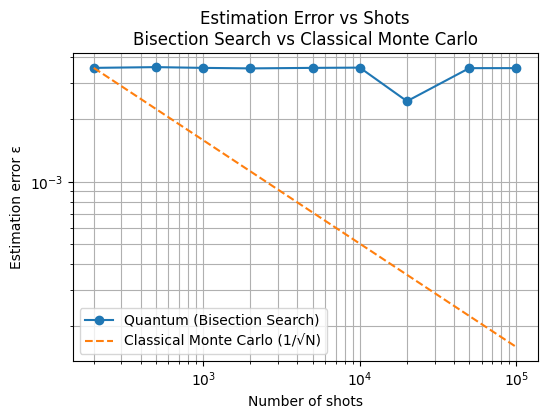

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Shot counts
shots = np.array([200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000])

# Bisection search estimation error (from your results)
eps_bisection = np.array(rmse_history)

# Classical Monte Carlo reference (O(1/sqrt(N)))
C = eps_bisection[0] * np.sqrt(shots[0])  # match first data point
eps_mc = C / np.sqrt(shots)

plt.figure(figsize=(6, 4))

plt.loglog(shots, eps_bisection, 'o-', label="Quantum (Bisection Search)")
plt.loglog(shots, eps_mc, '--', label="Classical Monte Carlo (1/√N)")

plt.xlabel("Number of shots")
plt.ylabel("Estimation error ε")
plt.title("Estimation Error vs Shots\nBisection Search vs Classical Monte Carlo")
plt.grid(True, which="both")
plt.legend()

plt.show()